In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
def convert_prediction(X,y,pred):
    col_list =[] 
    for col in X.columns:
        if "open" in col:
            col_list.append(col)
        
    mean_5_day = np.mean(X.loc[:,col_list],axis=1)
    mean_5_day.index = y.index
    std_5_day = np.std(X.loc[:,col_list],axis=1)
    std_5_day.index = y.index
    a = pd.DataFrame(index = y.index,columns=['mean','std','pred'])
    a.loc[:,"mean"] = mean_5_day
    a.loc[:,"std"] = std_5_day
    a.loc[:,"pred"] = pred
    a.loc[:,"converted"] = pred*std_5_day+mean_5_day
    return a["converted"]

In [81]:
def convert_decision(stock,pred):
    h = np.array(pred)
    action = []
    status = "N"
    stock["5_sma"] = stock['open'].rolling(window=5,min_periods=1).mean()
    for i in range(0,5):
        action.append("NA")
    for i in range(5,len(h)):
        #print(stock.loc[stock.index[i],'5_sma'])
        if h[i-5] >= stock.loc[stock.index[i],'5_sma']:
            if status == "N":
                action.append("Buy")
                status = "Buy"
            else:
                action.append("Hold")
        else:
            if status == "Buy":
                action.append("Sell")
                status = "N"
            else:
                action.append("Hold")

    result = (pd.DataFrame(action,
                         columns=["Action"], index = pred.index))
                
    return result

# Backtesting From anthony

In [77]:
from math import floor

In [54]:
start_date = []
num_period = 10
period_year = 1

start = 2022-(num_period+period_year-1)
for i in range(num_period):
    start_date.append((start+i)*10000+101)


date_range_list={}
for i in start_date:
    date_range_list[i] = (i-101)+(period_year-1)*10000+1231

print(date_range_list)

stock_list = {"BlockChain":["COIN","NVDA","FB"],
              "Airline":["BA","GD","LMT",],
              "Traveling":["UBER","ABNB","MAR","BKNG"],
              "Semiconductors":["INTC","NVDA","QCOM","MU","AMD"],
              "Cloud Computing":["IBM", "AMZN","GOOG","CRM"],
              "Social Media":["TWTR","SNAP","PINS","FB"],
              "Entertainment":["DIS","NFLX","FB"],
              "Retail":["WMT","COST","TGT","BBY","HD"],
              "Franchise":["MCD", "YUM", "SBUX", "DPZ"],
              "Real Estate":["HST", "EQR", "AVB", "PLD", "SPG"],
              "Telecommunication":["T","TMUS","VZ","CMCSA","CHTR"],
              "Energy & Resources":["DOW", "DD"],
              "Luxury goods":["RACE","EL","PVH"]
                            }

start_date = "2000-01-01"
end_date = "2022-12-31"


do_nth_name = "Buy&Hold"
model_name = "WithModel"

backtest_col = ["Sector","Stock",
                "Range_Start","Range_End",
                do_nth_name+"_Profit",model_name+"_Profit",
                do_nth_name+"_CAGR(in %)",model_name+"_CAGR(in %)",
                "CAGR_Performance(in %)",
                do_nth_name+"_MDD(in %)",model_name+"_MDD(in %)",
                "MDD_Performance(in %)"]

{20120101: 20121231, 20130101: 20131231, 20140101: 20141231, 20150101: 20151231, 20160101: 20161231, 20170101: 20171231, 20180101: 20181231, 20190101: 20191231, 20200101: 20201231, 20210101: 20211231}


In [79]:
################### Input ##########################
# For hist_price_data: index=["date"], columns = ["Open"]
# For pred_action: index=["date"], columns = ["Action"] (Buy/Sell)
################### Output #########################
# 1. trading record
# 2. total profit
class backtest:
    hpd = ""
    pred_action=pd.DataFrame()
    trade_record=pd.DataFrame(index=[],
                              columns=["Action","Price","Position","Cash","Pos_Bal","Cash_Bal","Cum_Profit","Total_Bal"],
                             )
    capital = 0
    cash_balance = 0
    profit = 0
    handle_fee = 0
    position = 0
    last_price = 0
    do_nth_profit = 0
    num_year = 0
    _tested = False
    
    _stock_trough = 0
    _stock_peak = 0
    _stock_all_time_low = 0
    _stock_all_time_high = 0
    
    _portfolio_trough = 0
    _portfolio_peak = 0
    _portfolio_all_time_low = 0
    _portfolio_all_time_high = 0
    
    def __init__(self,hist_price_data,pred_action,capital,handling_fee,num_year=1):
        self.hpd = hist_price_data
        self.pred_action = pred_action
        self.capital = capital
        self.cash_balance = capital
        self._portfolio_trough = capital
        self._portfolio_peak = capital
        self._portfolio_all_time_low = capital
        self._portfolio_all_time_high = capital
        self.handle_fee = handling_fee
        self.num_year = num_year  
        
    def clear_trade_record(self,sec):
        self.trade_record=pd.DataFrame(index=[],
                                       columns=["Action","Price","Position","Cash","Pos_Bal","Cash_Bal","Cum_Profit","Total_Bal"],
                                       )
        print("Clearing trade_record...")
        time.sleep(sec)
        
    def start_test(self): 
        if not self._tested:
            status = "sell"
            self._tested = True
            print("Start Backtesting...")  
            self._stock_all_time_low = self.hpd.iloc[0,0]
            self._stock_all_time_high = self.hpd.iloc[0,0]
            self._stock_trough = self.hpd.iloc[0,0]
            self._stock_peak = self.hpd.iloc[0,0]
            # For loop to iterate the data
            for ind in self.pred_action.index:
                # Update latest price
                self.last_price = self.hpd.loc[ind,"Open"]
                
                # Mark All Time Low,High , Trough and Peak for MDD of stock price (using "Buy&Hold")
                if self.last_price > self._stock_all_time_high:
                    self._stock_all_time_high = self.last_price
                if self.last_price < self._stock_all_time_low:
                    self._stock_all_time_low = self.last_price
                if self.last_price > self._stock_all_time_low and self._stock_trough != self._stock_all_time_low:
                    self._stock_trough = self._stock_all_time_low
                if self.last_price < self._stock_all_time_high and self._stock_peak != self._stock_all_time_high:
                    self._stock_peak = self._stock_all_time_high
                
                # Do the action
                if self.pred_action.loc[ind,"Action"].lower() == "buy" and status == "sell":
                    self._buy(ind,self.last_price)
                    status = "buy"
                elif self.pred_action.loc[ind,"Action"].lower() == "sell" and status == "buy":
                    self._sell(ind,self.last_price)
                    status = "sell"
                else:
                    #print("Did not buy at " + str(ind))
                    pass
                
                curr_portfolio_val = self.get_capital()+self.get_profit()
                
                # Mark All Time Low,High , Trough and Peak for MDD of our portfolio balance (using our model)
                if curr_portfolio_val > self._portfolio_all_time_high:
                    self._portfolio_all_time_high = curr_portfolio_val
                if curr_portfolio_val < self._portfolio_all_time_low:
                    self._portfolio_all_time_low = curr_portfolio_val
                if curr_portfolio_val > self._portfolio_all_time_low and self._portfolio_trough != self._portfolio_all_time_low:
                    self._portfolio_trough = self._portfolio_all_time_low
                if curr_portfolio_val < self._portfolio_all_time_high and self._portfolio_peak != self._portfolio_all_time_high:
                    self._portfolio_peak = self._portfolio_all_time_high
                            
            # =================================================
            self._run_do_nothing() # Calculate do nothing profit
        else:
            print("Backtesting has been completed...")
              
                
        
    def _mark_down_record(self,date,action,price,pos_delta,cash_delta):
        self.trade_record.loc[date] = [action,price,pos_delta,cash_delta,
                                       round(self.position,4),round(self.cash_balance,3),
                                       round(self.get_profit(),3),round(self.get_amount(),3)]
        
    def _buy(self,date,price):
        # Assume use all money to buy all
        buy_pos = floor(self.cash_balance / price)
        for i in range(buy_pos+1):
            act_buy_pos = buy_pos - i
            if act_buy_pos == 0:
                #print("You do not have enough money to buy!")
                return
            total_amt = act_buy_pos*price*(1+self.handle_fee)
            if self.cash_balance > total_amt:
                self.position += act_buy_pos
                self.cash_balance -= total_amt
                self._mark_down_record(date,
                                       "Buy",
                                       price,
                                       act_buy_pos,
                                       -total_amt)
                print("Bought at",date,"with price =", price, "\tPos:", act_buy_pos)
                return
        
    
    def _sell(self,date,price):
        # Assume sell all position
        sell_pos = self.position
        total_amt = sell_pos*price*(1-self.handle_fee)
        if self.position >= 1:
            self.position -= sell_pos
            self.cash_balance += total_amt
            self._mark_down_record(date,
                                   "Sell",
                                   price,
                                   -sell_pos,
                                   total_amt)
            print("Sold at",date,"with price =", price, "\tPos:", sell_pos)
            
            return

    def _run_do_nothing(self):
        balance = self.capital
        first_day_price = self.hpd.iloc[0,0]
        last_day_price = self.hpd.iloc[-1,0]
        buy_pos = floor(self.capital / first_day_price) # Calculate how many position can buy
        total_amt = buy_pos*first_day_price*(1+self.handle_fee) # Check if okay to buy (including fee)
        while self.capital < total_amt: # If not enough, reduce buy_pos by 1
            buy_pos -= 1
            total_amt = buy_pos*first_day_price*(1+self.handle_fee)
        position = buy_pos # Buy in 
        balance -= total_amt
        self.do_nth_profit = last_day_price*position+balance-self.capital

    def get_performance(self):
        if self._tested:
            model_profit = self.get_profit()
            do_nth_profit = self.get_do_nothing()
            perf = (model_profit-do_nth_profit)/abs(do_nth_profit)
            return perf
        else:
            print("No Backtesting Record.")

    def get_do_nothing(self):
        if self._tested:
            return self.do_nth_profit
        else:
            print("No Backtesting Record.")

    def get_profit(self):
        if self._tested:
            return self.get_cash_balance()+self.get_last_price()*self.get_position()-self.get_capital()
        else:
            print("No Backtesting Record.")

    def get_last_price(self):
        if self._tested:
            return self.last_price
        else:
            print("No Backtesting Record.")
    
    def get_position(self):
        if self._tested:
            return self.position
        else:
            print("No Backtesting Record.")
    
    def get_do_nothing_CAGR(self):
        if self._tested:
            start_bal = self.get_capital()
            end_bal = self.get_do_nothing()+self.get_capital()
            num_year = self.get_num_year()
            return pow(end_bal/start_bal,1/num_year)-1
        else:
            print("No Backtesting Record.")
            
    def get_model_CAGR(self):
        if self._tested:
            start_bal = self.get_capital()
            end_bal = self.get_profit()+self.get_capital()
            num_year = self.get_num_year()
            return pow(end_bal/start_bal,1/num_year)-1
        else:
            print("No Backtesting Record.")
            
    def get_diff_in_CAGR(self):
        if self._tested:
            return self.get_model_CAGR() - self.get_do_nothing_CAGR()
        else:
            print("No Backtesting Record.")
    
    def get_do_nothing_MDD(self):
        if self._tested:
            return (self._stock_trough-self._stock_peak)/self._stock_peak
        else:
            print("No Backtesting Record.")
            
    def get_model_MDD(self):
        if self._tested:
            return (self._portfolio_trough-self._portfolio_peak)/self._portfolio_peak
        else:
            print("No Backtesting Record.")
            
    def get_diff_in_MDD(self):
        if self._tested:
            return self.get_model_MDD() - self.get_do_nothing_MDD()
        else:
            print("No Backtesting Record.")
    
    def get_num_year(self):
        return self.num_year
    
    def get_cash_balance(self):
        return self.cash_balance
    
    def get_capital(self):
        return self.capital
    
    def get_amount(self):
        return self.get_capital()+self.get_profit()

    def print_do_nothing(self):
        if self._tested:
            print("If buy at", self.hpd.index[0],"with price =",self.hpd.iloc[0,0])
            print("and do nothing")
            print("Current Profit:",self.get_do_nothing())
        else:
            print("No Backtesting Record.")
            
    def print_performance(self):
        if self._tested:
            print("Performance:", str(round(self.get_performance()*100,2))+"%")
        else:
            print("No Backtesting Record.")
            
    def print_CAGR_performance(self):
        if self._tested:
            print("CAGR Performance:", str(round(self.get_diff_in_CAGR()*100,2))+"%")
        else:
            print("No Backtesting Record.")
    
    def print_trade_record(self):
        if self._tested:
            print(self.trade_record)
        else:
            print("No Backtesting Record.")
            print(self.trade_record)
    
    def print_profit(self):
        if self._tested:
            print("Current Profit with model:",self.get_profit())
        else:
            print("No Backtesting Record.")
    
    def export_trade_record(self,stock,add_msg = ""):
        if self._tested:
            # Save the trade record to the path
            if not add_msg == "":
                add_msg = "_" + add_msg
            self.trade_record = self.trade_record.sort_index()
            self.trade_record.to_csv("./trade_record/"+stock+add_msg+".csv")
            print("Trade record exported.")
        else:
            print("No Backtesting Record.")

In [56]:
def get_last_n_day_mean(df,n):
    series = df["open"]
    windows = series.rolling(n)
    n_days_averages = windows.mean()
    n_days_list = n_days_averages.tolist()
    final_list = n_days_list[n:]
    new_df = pd.DataFrame(final_list,columns=["mean_"+str(n)],index=df.index[n:])
    return new_df

In [ ]:

mean_backtest_summary = backtest_summary.groupby("Stock")[["Stock",
                                                          do_nth_name+"_Profit",
                                                          model_name+"_Profit",
                                                          do_nth_name+"_CAGR(in %)",
                                                          model_name+"_CAGR(in %)",
                                                          "CAGR_Performance(in %)",
                                                          do_nth_name+"_MDD(in %)",
                                                          model_name+"_MDD(in %)",
                                                          "MDD_Performance(in %)"]].mean()

mean_backtest_summary = mean_backtest_summary.add_prefix("mean_")

mean_backtest_summary = mean_backtest_summary.round(decimals = 2)
mean_backtest_summary.to_csv("backtest_summary_SVR_mean.csv")

#1. Library Import

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import os.path as osp
import torch.utils.data as data
import torch.nn.functional as F

from tqdm import tqdm
import time, matplotlib, torch, os
from statsmodels.tsa.arima_model import ARIMA
from torch.utils.tensorboard import SummaryWriter

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import os
from os import walk

import plotly
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime
#import seaborn as sns

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [6]:
#For DNN / CNN+LSTM
import keras.backend as K
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Flatten, Dense

In [7]:
!pip install -q stockstats

In [8]:
import pandas_datareader.data as web
from stockstats import StockDataFrame

#Setting the index values as timestamp
def process(code):
  print("Enter the code of the model that you want to implement")
  #code = input()
  #final_code = '^'+code
  final_code = code
  start_date = "2012-01-01"
  end_date = "2021-12-31"
  stock = web.DataReader(final_code , 'stooq',start=start_date, end=end_date)
  stock.columns = ["open","high","low","close","volume"]
  
  # Use online package to generate additional features
  x = StockDataFrame(stock)
  stock = x[['open','high','low','close','volume',
          'boll', 'boll_ub', 'boll_lb',
          'macd', 'macdh', 'macds',
          'rsi_11', 'rsi_14', 'rsi_21']]
  stock.index = [int(str(ind)[0:4]+str(ind)[5:7]+str(ind)[8:10]) for ind in stock.index]
  stock = stock.sort_index()

  return stock

In [66]:


stock = process("AAPL")

Enter the code of the model that you want to implement


In [67]:
stock

,open,high,low,close,volume,boll,boll_ub,boll_lb,macd,macdh,macds,rsi_11,rsi_14,rsi_21
20120103,12.534,12.615,12.508,12.576,352894245,13.106700,13.921861,12.291539,-0.578224,0.072151,-0.650375,21.706747,22.358632,24.649180
20120104,12.541,12.681,12.516,12.644,303804192,13.175450,14.032984,12.317916,-0.589238,0.079175,-0.668413,22.846861,23.193766,25.175611
20120105,12.689,12.800,12.620,12.785,316465495,13.239150,14.119434,12.358866,-0.601649,0.086557,-0.688206,25.357455,24.991067,26.284158
20120106,12.838,12.930,12.821,12.919,371746847,13.302750,14.227554,12.377946,-0.623095,0.086750,-0.709846,28.017387,26.825484,27.375164
20120109,13.011,13.080,12.887,12.899,459928530,13.366250,14.352474,12.380026,-0.655049,0.076485,-0.731533,26.978064,26.073421,26.944118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211227,176.860,180.190,176.840,180.100,75015032,178.724000,180.885416,176.562584,0.115872,0.052572,0.063300,96.816851,96.840918,96.872000
20211228,179.930,181.100,178.300,179.060,79245171,178.380000,180.133093,176.626907,0.068420,0.027381,0.041039,94.653640,94.794464,94.958656
20211229,179.100,180.400,177.910,179.150,62428366,178.153333,179.990977,176.315690,0.054602,0.027590,0.027012,100.000000,100.000000,100.000000
20211230,179.240,180.340,177.860,177.970,59849167,177.655000,178.545955,176.764045,0.014135,0.006282,0.007853,100.000000,100.000000,100.000000


# Data preprocessing for regression models

 Split the train and test data

In [10]:
# Split the train and test data
def custom_split(data,start,end):
    train = (data.index >= start) & (data.index <= end)
    train_X = data[train]
    
    return train_X

In [11]:
train_X = custom_split(stock,start = 20130101,end = 20171031)
valid_X = custom_split(stock,start = 20171101,end = 20181231)
test_X = custom_split(stock,start = 20190101,end = 20201231)

In [12]:
print(len(train_X))
print(len(valid_X))
print(len(test_X))

1218
292
505


Label the target result (opening price on 11th day)

In [13]:
# Assume we use 10 days price data to predict closing price of the 11th day
num_day_to_predict = 5

In [14]:
def produce_result_target_price(X,num_day = 5,result_col_name = "result_price"):
    y = pd.DataFrame(np.nan, index=X.index, columns=[result_col_name])
    for i in range(5,len(X)):
        y.loc[X.index[i-1],result_col_name] = X.loc[X.index[i],"open"]
    
    return y

In [15]:
train_y = produce_result_target_price(train_X,num_day_to_predict)
valid_y = produce_result_target_price(valid_X,num_day_to_predict)
test_y = produce_result_target_price(test_X,num_day_to_predict)

In [16]:
print(len(train_y))
print(len(valid_y))
print(len(test_y))

1218
292
505


In [17]:
pred_y = produce_result_target_price(stock,num_day_to_predict)

Transform the 10-day data into one vector

In [18]:
def transform_x_data_to_one_vector(X,num_day):
    col_name = []
    for i in range(num_day):
        for j in X.columns:
            col_name.append(j+"-"+str(i))
    new_X = pd.DataFrame(np.nan, index=X.index, columns=col_name)
    
    for i in range(num_day-1,len(X)):
        for col in col_name:
            split_list = col.split("-")
            new_X.loc[X.index[i],col] = X.loc[X.index[i-int(split_list[1])],split_list[0]]
    
    return new_X

In [19]:
train_X_5 = transform_x_data_to_one_vector(train_X,num_day_to_predict)
valid_X_5 = transform_x_data_to_one_vector(valid_X,num_day_to_predict)
test_X_5 = transform_x_data_to_one_vector(test_X,num_day_to_predict)

In [20]:
pred_X_5 = transform_x_data_to_one_vector(stock,num_day_to_predict)

In [21]:
print(len(train_X_5))
print(len(valid_X_5))
print(len(test_X_5))
print(len(pred_X_5))

1218
292
505
2517


 Drop out rows with NaN

In [22]:
def drop_nan_row_y(y,num_day = 5):
    drop_list = [y.index[i] for i in range(num_day-1)]
    drop_list.append(y.index[-1])
    return y.drop(drop_list)

def drop_nan_row_X_5(X,num_day = 5):
    drop_list = [X.index[i] for i in range(num_day-1)]
    drop_list.append(X.index[-1])
    return X.drop(drop_list)

In [23]:
new_train_X_5 = drop_nan_row_X_5(train_X_5,num_day_to_predict)
new_train_y = drop_nan_row_y(train_y,num_day_to_predict)

new_valid_X_5  = drop_nan_row_X_5(valid_X_5,num_day_to_predict)
new_valid_y = drop_nan_row_y(valid_y,num_day_to_predict)

new_test_X_5  = drop_nan_row_X_5(test_X_5,num_day_to_predict)
new_test_y = drop_nan_row_y(test_y,num_day_to_predict)

In [24]:
new_pred_X_5  = drop_nan_row_X_5(pred_X_5,num_day_to_predict)
new_pred_y = drop_nan_row_y(pred_y,num_day_to_predict)

In [25]:
print(len(new_train_X_5))
print(len(new_valid_X_5))
print(len(new_test_X_5))
print(len(new_pred_X_5))

1213
287
500
2512


In [26]:
print(len(new_train_y))
print(len(new_valid_y))
print(len(new_test_y))
print(len(new_pred_y))

1213
287
500
2512


In [27]:
# Keep a copy for reverting prediction result
old_train_X_5 = new_train_X_5
old_train_y = new_train_y
old_valid_X_5 = new_valid_X_5
old_valid_y = new_valid_y
old_test_X_5 = new_test_X_5
old_test_y = new_test_y

In [28]:
old_pred_X_5 = new_pred_X_5
old_pred_y = new_pred_y

In [29]:
### Normalize data row by row

In [30]:
def normalize_data_by_row(X,y):
    norm_X = X.sub(X.mean(axis=0), axis=1).div(X.std(axis=0), axis=1)
    
    col_list =[] 
    for col in X.columns:
        if "open" in col:
            col_list.append(col)
    
    temp_y = y.loc[:,"result_price"]
    mean_5_day = np.mean(X.loc[:,col_list],axis=1)
    mean_5_day.index = temp_y.index
    std_5_day = np.std(X.loc[:,col_list],axis=1)
    std_5_day.index = temp_y.index
    

    norm_y = pd.DataFrame((temp_y-mean_5_day)/std_5_day,
                          columns=["result_price"])
                         
    return (norm_X,norm_y)

In [31]:
new_train_X_5,new_train_y = normalize_data_by_row(new_train_X_5,new_train_y)
new_valid_X_5,new_valid_y = normalize_data_by_row(new_valid_X_5,new_valid_y)
new_test_X_5,new_test_y = normalize_data_by_row(new_test_X_5,new_test_y)

In [32]:
new_pred_X_5,new_pred_y = normalize_data_by_row(new_pred_X_5,new_pred_y)

In [33]:
new_train_X_5 = drop_nan_row_X_5(new_train_X_5,num_day_to_predict)
new_valid_X_5 = drop_nan_row_X_5(new_valid_X_5,num_day_to_predict)
new_test_X_5 = drop_nan_row_X_5(new_test_X_5,num_day_to_predict)

In [34]:
new_train_y = drop_nan_row_y(new_train_y,num_day_to_predict)
new_valid_y = drop_nan_row_y(new_valid_y,num_day_to_predict)
new_test_y = drop_nan_row_y(new_test_y,num_day_to_predict)

In [35]:
new_train_X_5

,open-0,high-0,low-0,close-0,volume-0,boll-0,boll_ub-0,boll_lb-0,macd-0,macdh-0,...,volume-4,boll-4,boll_ub-4,boll_lb-4,macd-4,macdh-4,macds-4,rsi_11-4,rsi_14-4,rsi_21-4
20130114,-1.243397,-1.245476,-1.239024,-1.247156,3.431200,-1.386522,-1.299085,-1.470331,1.378538,0.795152,...,1.580685,-1.339437,-1.196806,-1.481843,1.726437,0.941709,1.537264,1.478666,1.573085,1.729566
20130115,-1.263116,-1.283576,-1.307601,-1.318685,4.375646,-1.393449,-1.313787,-1.468934,1.332043,0.848694,...,1.244494,-1.354654,-1.221435,-1.486954,1.660094,0.968388,1.457359,1.303522,1.410626,1.581676
20130116,-1.279768,-1.236751,-1.266190,-1.227741,3.142584,-1.397038,-1.319250,-1.470505,1.386127,1.236123,...,2.523879,-1.364994,-1.242452,-1.485879,1.622165,1.093584,1.375243,1.552061,1.634114,1.772642
20130117,-1.209217,-1.230789,-1.223164,-1.242923,1.562082,-1.405212,-1.340193,-1.465028,1.279037,1.206820,...,0.868257,-1.375226,-1.270661,-1.476939,1.505036,0.994064,1.282756,1.494364,1.578583,1.719868
20130118,-1.262240,-1.268889,-1.248716,-1.255039,1.696101,-1.414070,-1.361314,-1.460771,1.156405,1.120665,...,3.404561,-1.383636,-1.297155,-1.466077,1.363974,0.792298,1.198513,1.119181,1.220815,1.384523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20171023,1.943510,1.934737,1.935634,1.917349,-0.920973,2.285301,2.497676,2.043877,-2.064063,-3.439142,...,-0.996209,2.223695,2.508554,1.905823,-2.038818,-1.139197,-1.806438,-0.299367,-0.399940,-0.438388
20171024,1.922476,1.924848,1.959717,1.949318,-1.025394,2.310024,2.480164,2.113403,-1.819449,-3.516536,...,-1.061480,2.243513,2.528149,1.925741,-2.203613,-1.950993,-1.713954,-0.466469,-0.548818,-0.558286
20171025,1.944386,1.929647,1.927558,1.925378,-0.939883,2.338640,2.467410,2.185875,-1.531910,-3.476498,...,-0.433499,2.260660,2.536005,1.952644,-2.331416,-2.846162,-1.554217,-1.471553,-1.414561,-1.227602
20171026,1.955633,1.939100,1.979835,1.960705,-1.042442,2.371537,2.441871,2.280769,-1.094399,-2.948555,...,-0.877504,2.287828,2.537112,2.007319,-2.224620,-3.206776,-1.320321,-1.450880,-1.394068,-1.207624


# DNN

In [ ]:
cd /content/drive/MyDrive/fyp/'Final report'/'4. Backtesting'/from_anthony/prediction_record

/content/drive/.shortcut-targets-by-id/1htSPx3abzIkrvFm5B3GKMcILQdrWf_XZ/fyp/Final report/4. Backtesting/from_anthony/prediction_record


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
#Data Pre-processing
train_df = stock

X = train_df[['open', 'high', 'low', 'volume', 'boll', 'boll_ub', 'boll_lb',
       'macd', 'macdh', 'macds', 'rsi_11', 'rsi_14', 'rsi_21']]
Y = train_df[['close']]

X_scaler = MinMaxScaler(feature_range=(0, 1))
X[X.columns] = X_scaler.fit_transform(X[X.columns])
X = X.fillna(X.median())

Y_scaler = MinMaxScaler(feature_range=(0, 1))
Y[Y.columns] = Y_scaler.fit_transform(Y[Y.columns])
Y = Y.fillna(Y.median())

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.25)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
#Model

model = keras.Sequential(
    [
        layers.Dense(64, activation="relu", input_shape=(70,)),
        layers.Dense(128, activation="relu", name="layer1"),
        layers.Dense(256, activation="relu", name="layer2"),
        layers.Dense(1,activation="linear", name="layer3")
    ]
)

model.compile(loss='mean_squared_error',optimizer='adam')
history = model.fit(new_train_X_5, new_train_y,validation_data=(new_valid_X_5, new_valid_y),epochs = 200 ,batch_size = 10,verbose=False)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                4544      
                                                                 
 layer1 (Dense)              (None, 128)               8320      
                                                                 
 layer2 (Dense)              (None, 256)               33024     
                                                                 
 layer3 (Dense)              (None, 1)                 257       
                                                                 
Total params: 46,145
Trainable params: 46,145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
dnn_predict = model.predict(new_pred_X_5)
'''
print('SIMPLE DNN PERFORMANCE')
print('r2 score: '+str(r2_score(new_test_y, dnn_predict)))
print('RMSE : '+str(np.sqrt(mean_squared_error(new_test_y, dnn_predict))))
print("Mean Absolute Error : " + str(mean_absolute_error(new_test_y,dnn_predict)))
'''

'\nprint(\'SIMPLE DNN PERFORMANCE\')\nprint(\'r2 score: \'+str(r2_score(new_test_y, dnn_predict)))\nprint(\'RMSE : \'+str(np.sqrt(mean_squared_error(new_test_y, dnn_predict))))\nprint("Mean Absolute Error : " + str(mean_absolute_error(new_test_y,dnn_predict)))\n'

In [ ]:
def flatten(t):
    return [x for y in t for x in y]
final_pred_ = flatten(dnn_predict)

In [ ]:
len(final_pred_)
stock.index

final_ = pd.DataFrame(list(zip(stock.index,final_pred_)),columns = ["Date","Prediction"])
final_ = final_.set_index("Date")

In [ ]:
final_

,Prediction
Date,
20100104,-0.765556
20100105,-1.253247
20100106,-2.009471
20100107,-1.011565
20100108,-0.885878
...,...
20211217,2.038799
20211220,3.838384
20211221,1.209074


In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1htSPx3abzIkrvFm5B3GKMcILQdrWf_XZ/fyp/Final report/4. Backtesting/from_anthony/prediction_record'

In [ ]:
len(old_pred_X_5)
len(final_pred_)

3021

In [ ]:
DNN_final = convert_prediction(old_pred_X_5,old_pred_y,final_pred_)

20100108      6.473565
20100111      6.446451
20100112      6.365301
20100113      6.384436
20100114      6.383784
               ...    
20211223    176.814322
20211227    184.947003
20211228    178.975727
20211229    172.730719
20211230    174.667414
Name: converted, Length: 3016, dtype: float64

In [ ]:
action_dnn = convert_decision(stock,DNN_final)
action_dnn['pred_price'] = DNN_final.tolist()

[  6.47356478   6.44645149   6.36530132 ... 178.97572734 172.73071938
 174.66741376]


In [ ]:
code = "AAPL"
file_name = f"DNN_{code}"
action_dnn.to_csv(f"{file_name}.csv")

# XGB

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor(learning_rate = 0.01,n_estimators=1000)

model.fit(new_train_X_5, new_train_y, early_stopping_rounds=5, eval_set=[(new_valid_X_5, new_valid_y)], verbose=False)
xgb_pred_y = model.predict(new_test_X_5)

[16:03:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
#Performance evaluation
print('XGBOOST PERFORMANCE')
print('r2 score: '+str(r2_score(new_test_y, xgb_pred_y)))
print('RMSE : '+str(np.sqrt(mean_squared_error(new_test_y, xgb_pred_y))))
print("Mean Absolute Error : " + str(mean_absolute_error(new_test_y,xgb_pred_y)))

XGBOOST PERFORMANCE
r2 score: 0.26179669411654083
RMSE : 1.8570170862253996
Mean Absolute Error : 1.2079023989947142


In [ ]:
xgb_final_pred = model.predict(new_pred_X_5)
xgb_final_pred

array([-1.097138 , -1.3405771, -1.3057923, ...,  2.9223764,  2.1782866,
        0.9583242], dtype=float32)

In [ ]:
len(xgb_final_pred)

3016

In [ ]:
new_pred_X_5

,open-0,high-0,low-0,close-0,volume-0,boll-0,boll_ub-0,boll_lb-0,macd-0,macdh-0,...,volume-4,boll-4,boll_ub-4,boll_lb-4,macd-4,macdh-4,macds-4,rsi_11-4,rsi_14-4,rsi_21-4
20100108,-2.262660,-2.240345,-2.202227,-2.183855,-0.022944,-2.413894,-2.362662,-2.348560,0.628492,0.462650,...,0.810279,-2.341758,-2.315216,-2.255806,0.611368,0.217711,0.580860,1.054480,1.050621,1.002419
20100111,-2.169561,-2.233675,-2.218946,-2.247719,0.631644,-2.435339,-2.371603,-2.381674,0.620193,0.554086,...,1.102030,-2.358241,-2.334855,-2.268284,0.563755,0.130901,0.560934,0.706930,0.736951,0.730741
20100112,-2.263748,-2.221562,-2.204810,-2.200740,1.631360,-2.450302,-2.381101,-2.401464,0.658248,0.806413,...,0.576411,-2.370610,-2.346269,-2.281027,0.561282,0.156826,0.548871,0.502959,0.556151,0.577272
20100113,-2.200775,-2.231294,-2.197402,-2.212110,0.939553,-2.468634,-2.399488,-2.418849,0.656197,1.002398,...,0.676770,-2.387292,-2.346594,-2.313546,0.586024,0.270289,0.534460,0.400291,0.465027,0.499764
20100114,-2.194451,-2.156640,-2.161450,-2.116859,1.218644,-2.484165,-2.421178,-2.427362,0.654953,1.249780,...,-0.024916,-2.401664,-2.350703,-2.337665,0.627624,0.462325,0.509772,0.763963,0.791835,0.772654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211223,0.492285,0.494683,0.519648,0.533687,-0.735107,0.677971,0.481262,0.844962,-0.048637,-0.172823,...,1.237605,0.560096,0.535935,0.557659,-0.290128,-0.453125,-0.148903,-2.910803,-3.282351,-3.993219
20211227,0.535128,0.540959,0.548192,0.599730,-0.545810,0.705635,0.460347,0.920665,-0.004786,-0.105786,...,-0.358023,0.586930,0.537626,0.608779,-0.241317,-0.437940,-0.101732,-3.344072,-3.736195,-4.497259
20211228,0.599733,0.646440,0.658291,0.667815,-0.794339,0.730148,0.434425,0.995256,0.028920,-0.049388,...,-0.383078,0.623353,0.507684,0.710958,-0.152191,-0.303374,-0.054312,-3.259862,-3.638823,-4.375723
20211229,0.653457,0.713132,0.706544,0.716155,-0.561813,0.747657,0.414843,1.049620,0.048324,-0.015908,...,-0.656609,0.651435,0.497934,0.776173,-0.099162,-0.240692,-0.019799,-3.200834,-3.571417,-4.292727


In [ ]:
len(xgb_final_pred)

3016

In [ ]:
print(len(pred_X_5))
print(len(pred_y))
print(len(xgb_final_pred))

3021
3021
3016


In [ ]:
xgb_final_pred

array([-0.56757915, -1.0979575 , -0.34278464, ...,  1.6768429 ,
        1.5819079 ,  2.972342  ], dtype=float32)

In [ ]:
xgb_final_pred_converted = convert_prediction(old_pred_X_5,old_pred_y,xgb_final_pred)
xgb_final_pred_converted

20100108     88.560964
20100111     88.220028
20100112     88.351178
20100113     88.408044
20100114     88.591389
               ...    
20211223    128.791117
20211227    130.029607
20211228    130.478939
20211229    131.012639
20211230    133.990175
Name: converted, Length: 3016, dtype: float64

Function to generate the prediction comparison with the window=5 average, among the options enum {BUY,SELL,HOLD}

In [ ]:
def convert_decision(stock,pred):
    h = np.array(pred)
    action = []
    status = "N"
    stock["5_sma"] = stock['open'].rolling(window=5,min_periods=1).mean()
    print(h)
    for i in range(0,5):
        action.append("NA")
    for i in range(5,len(h)):
        #print(stock.loc[stock.index[i],'5_sma'])
        if h[i-5] >= stock.loc[stock.index[i],'5_sma']:
            if status == "N":
                action.append("Buy")
                status = "Buy"
            else:
                action.append("Hold")
        else:
            if status == "Buy":
                action.append("Sell")
                status = "N"
            else:
                action.append("Hold")

    result = (pd.DataFrame(action,
                         columns=["Action"], index = pred.index))
                
    return result

In [ ]:
action = convert_decision(stock,xgb_final_pred_converted)
action['pred_price'] = xgb_final_pred_converted.tolist()

[ 88.56096434  88.220028    88.351178   ... 130.47893913 131.01263873
 133.99017453]


In [ ]:
action[action["Action"]=="Sell"]

,Action,pred_price
20100212,Sell,83.985311
20100301,Sell,86.748069
20100309,Sell,86.543543
20100324,Sell,87.409636
20100331,Sell,87.866571
...,...,...
20210915,Sell,133.788647
20210922,Sell,132.480825
20211012,Sell,138.570250
20211111,Sell,117.996534


In [ ]:
action.to_csv('XGB_IBM.csv')

# Catboost

In [37]:
pip install -q catboost

     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [38]:
from catboost import CatBoostRegressor

model_cat = CatBoostRegressor(random_state=1002,logging_level='Silent')

model_cat.fit(new_train_X_5, new_train_y, plot=True)
pred_cat = model_cat.predict(new_test_X_5, verbose=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [39]:
#Performance evaluation
print('CATBoost PERFORMANCE')
print('r2 score: '+str(r2_score(new_test_y, pred_cat)))
print('RMSE : '+str(np.sqrt(mean_squared_error(new_test_y, pred_cat))))
print("Mean Absolute Error : " + str(mean_absolute_error(new_test_y,pred_cat)))

CATBoost PERFORMANCE
r2 score: 0.3037475777938691
RMSE : 1.8034797334426473
Mean Absolute Error : 1.1911943062282442


In [47]:
import pickle

In [48]:
with open("Cat.pickle", "wb") as f:
    pickle.dump(model_cat, f)

In [40]:
cat_final_pred = model_cat.predict(new_pred_X_5)

In [41]:
cat_final_pred_converted = convert_prediction(old_pred_X_5,old_pred_y,cat_final_pred)
cat_final_pred_converted

20120109     12.942367
20120110     13.047731
20120111     12.998559
20120112     13.005688
20120113     13.007640
               ...    
20211223    177.803592
20211227    185.248173
20211228    181.788770
20211229    180.869626
20211230    178.926622
Name: converted, Length: 2512, dtype: float64

In [42]:
action_cat = convert_decision(stock,cat_final_pred_converted)
action_cat['pred_price'] = cat_final_pred_converted.tolist()

[ 12.94236655  13.04773111  12.9985592  ... 181.78876989 180.86962629
 178.92662245]


In [43]:
action_cat

,Action,pred_price
20120109,NA,12.942367
20120110,NA,13.047731
20120111,NA,12.998559
20120112,NA,13.005688
20120113,NA,13.007640
...,...,...
20211223,Sell,177.803592
20211227,Hold,185.248173
20211228,Hold,181.788770
20211229,Hold,180.869626


In [44]:
code = "AAPL"
file_name = f"CAT_{code}"
action_cat.to_csv(f"{file_name}.csv")

## Backtesting for Cat

In [72]:
start_date = []
num_period = 10
period_year = 1

start = 2022-(num_period+period_year-1)
for i in range(num_period):
    start_date.append((start+i)*10000+101)


date_range_list={}
for i in start_date:
    date_range_list[i] = (i-101)+(period_year-1)*10000+1231

print(date_range_list)

stock_list = {"BlockChain":["COIN","NVDA","FB"],
              "Airline":["BA","GD","LMT",],
              "Traveling":["UBER","ABNB","MAR","BKNG"],
              "Semiconductors":["INTC","NVDA","QCOM","MU","AMD"],
              "Cloud Computing":["IBM", "AMZN","GOOG","CRM"],
              "Social Media":["TWTR","SNAP","PINS","FB"],
              "Entertainment":["DIS","NFLX","FB"],
              "Retail":["WMT","COST","TGT","BBY","HD"],
              "Franchise":["MCD", "YUM", "SBUX", "DPZ"],
              "Real Estate":["HST", "EQR", "AVB", "PLD", "SPG"],
              "Telecommunication":["T","TMUS","VZ","CMCSA","CHTR"],
              "Energy & Resources":["DOW", "DD"],
              "Luxury goods":["RACE","EL","PVH"]
                            }

start_date = "2000-01-01"
end_date = "2022-12-31"


do_nth_name = "Buy&Hold"
model_name = "WithModel"

backtest_col = ["Sector","Stock",
                "Range_Start","Range_End",
                do_nth_name+"_Profit",model_name+"_Profit",
                do_nth_name+"_CAGR(in %)",model_name+"_CAGR(in %)",
                "CAGR_Performance(in %)",
                do_nth_name+"_MDD(in %)",model_name+"_MDD(in %)",
                "MDD_Performance(in %)"]

{20120101: 20121231, 20130101: 20131231, 20140101: 20141231, 20150101: 20151231, 20160101: 20161231, 20170101: 20171231, 20180101: 20181231, 20190101: 20191231, 20200101: 20201231, 20210101: 20211231}


In [59]:
def standard_date_format(date_in_num):
    date = str(date_in_num)
    new_date = date[0:4] + "-" + date[4:6] + "-" + date[6:8] 
    return new_date

In [60]:
# Some Settings and Constants
other_start_date = "2010-01-01"
other_end_date = "2021-12-31"

folder_path = "other_model/"


In [82]:
#### CAT Backtest
backtest_summary = pd.DataFrame(columns=backtest_col)
with open("Cat.pickle", "rb") as f:
    cat_test = pickle.load(f)
    
for sector, stocks in stock_list.items():
    for stock in stocks:
        print("Runninng stock: "+ stock)
        stock_data_1 = web.DataReader(stock, "stooq",start=start_date, end=end_date)
        stock_data_1.columns = ["open","high","low","close","volume"]
        x_1 = StockDataFrame(stock_data_1)
        data_1 = x_1[['open','high','low','close','volume',
                      'boll', 'boll_ub', 'boll_lb',
                      'macd', 'macdh', 'macds',
                      'rsi_11', 'rsi_14', 'rsi_21']]
        data_1.index = [int(str(ind)[0:4]+str(ind)[5:7]+str(ind)[8:10]) for ind in data_1.index]
        data_1 = data_1.sort_index()
        print(stock + " Data loaded...")
        
        for k,v in date_range_list.items():
         
            print("Getting Data... - " + stock + " from " + str(k))
            if (data_1.index[0]>v):
                print("No data for this testing period... - " + stock + " from " + str(k))
                continue
            test_X = custom_split(data_1,start = k,end = v)
            if len(test_X) <= num_day_to_predict:
                print("No enoguh data for testing... - " + stock + " from " + str(k))
                continue
                
            print("Transforming Data... - " + stock + " from " + str(k))
            test_y = produce_result_target_price(test_X,num_day_to_predict)
            test_X_5 = transform_x_data_to_one_vector(test_X,num_day_to_predict)
            new_test_X_5  = drop_nan_row_X_5(test_X_5,num_day_to_predict)
            new_test_y = drop_nan_row_y(test_y,num_day_to_predict)
            old_test_X_5 = new_test_X_5.copy()
            old_test_y = new_test_y.copy()
            new_test_X_5,new_test_y = normalize_data_by_row(new_test_X_5,new_test_y)
            
            print("Predicting... - " + stock + " from " + str(k))
            cat_prediction = cat_test.predict(new_test_X_5)
            
            print("Converting... - " + stock + " from " + str(k))
            pred_price = convert_prediction(old_test_X_5,old_test_y,cat_prediction)
    

            pred_action = convert_decision(data_1,pred_price)
            #pred_df["Action"] = pred_df.apply(lambda row: "Buy" if row["converted"] > row["mean"] else "Sell", axis=1)
            #final_pred = pred_df.drop(columns=["mean","std","pred","converted"])
            final_test_y = old_test_y.rename(columns={"result_price":"Open"})
            #final_pred = final_pred.sort_index()
            
            print("Backtesting... - " + stock + " from " + str(k))
            back1 = backtest(final_test_y,pred_action,10000,0.0005,period_year)
            back1.clear_trade_record(3)
            
            print("Start Iteration... - " + stock + " from " + str(k))
            back1.start_test()
            
            print("======= from "+ str(k) + " to " + str(v)+" =========")
            back1.print_do_nothing()
            back1.print_profit()
            back1.print_CAGR_performance()
            back1.export_trade_record("Cat_"+sector+"-"+stock,str(k)+"-to-"+str(v)+"("+str(round(back1.get_diff_in_CAGR()*100,2))+"%)")
            backtest_summary = backtest_summary.append({"Sector":sector,
                                                        "Stock":stock,
                                                        "Range_Start":str(k),
                                                        "Range_End":str(v),
                                                        do_nth_name+"_Profit":round(back1.get_do_nothing(),2),
                                                        model_name+"_Profit":round(back1.get_profit(),2),
                                                        do_nth_name+"_CAGR(in %)":round(back1.get_do_nothing_CAGR()*100,2),
                                                        model_name+"_CAGR(in %)":round(back1.get_model_CAGR()*100,2),
                                                        "CAGR_Performance(in %)":round(back1.get_diff_in_CAGR()*100,2),
                                                        do_nth_name+"_MDD(in %)":round(back1.get_do_nothing_MDD()*100,2),
                                                        model_name+"_MDD(in %)":round(back1.get_model_MDD()*100,2),
                                                        "MDD_Performance(in %)":round(back1.get_diff_in_MDD()*100,2)}, ignore_index=True)
            print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

print("Backtesting Completed...")
backtest_summary.to_csv("backtest_summary_Cat.csv")

Streaming output truncated to the last 5000 lines.
Start Backtesting...
Bought at 20120601 with price = 27.2 	Pos: 367
Sold at 20120604 with price = 26.7 	Pos: 367
Bought at 20120614 with price = 28.5 	Pos: 343
Sold at 20120627 with price = 31.96 	Pos: 343
Bought at 20120629 with price = 31.25 	Pos: 351
Sold at 20120702 with price = 30.91 	Pos: 351
Bought at 20120703 with price = 31.28 	Pos: 346
Sold at 20120705 with price = 31.44 	Pos: 346
Bought at 20120712 with price = 31.04 	Pos: 350
Sold at 20120716 with price = 28.48 	Pos: 350
Bought at 20120726 with price = 23.19 	Pos: 430
Sold at 20120730 with price = 23.37 	Pos: 430
Bought at 20120810 with price = 22.15 	Pos: 453
Sold at 20120821 with price = 19.36 	Pos: 453
Bought at 20120822 with price = 19.5 	Pos: 450
Sold at 20120823 with price = 19.52 	Pos: 450
Bought at 20120827 with price = 19.1 	Pos: 459
Sold at 20120828 with price = 19.32 	Pos: 459
Bought at 20120830 with price = 18.68 	Pos: 474
Sold at 20120831 with price = 18.08 	Po

In [ ]:
### Select Model and Stock
model_to_test = "XGB"
stock_to_test = "IBM"

### Get stock data from Stooq and transform it
other_stock_data = web.DataReader(stock_to_test, "stooq",start=other_start_date, end=other_end_date)
other_stock_data = other_stock_data.sort_index()
other_stock_data.drop(columns=["High","Low","Close","Volume"],inplace = True)
other_stock_data = other_stock_data.iloc[1:,]

### Get the prediction and convert it to action
other_pred = pd.read_csv(folder_path+model_to_test+"_"+stock_to_test+".csv", header = 0,usecols=[0,1,2])
other_pred = other_pred.rename(columns={other_pred.columns[0]:"Date"})
other_pred = other_pred.set_index(other_pred.columns[0])
other_pred.index = list(map(standard_date_format,other_pred.index))

### Drop the row that with NaN in action
index_to_drop = other_pred["Action"].index[other_pred["Action"].apply(lambda act: False if type(act)!= float else isnan(act))]
# Drop
other_pred.drop(index=index_to_drop,inplace=True)

In [ ]:
other_stock_data

,Open
Date,
2010-01-05,89.718
2010-01-06,89.049
2010-01-07,88.504
2010-01-08,87.939
2010-01-11,89.308
...,...
2021-12-27,129.080
2021-12-28,130.030
2021-12-29,130.820


In [ ]:
other_pred

,Action,pred_price
2010-01-15,Hold,89.073671
2010-01-19,Hold,87.492425
2010-01-20,Hold,88.159576
2010-01-21,Hold,88.174781
2010-01-22,Hold,87.031053
...,...,...
2021-12-23,Hold,128.791117
2021-12-27,Hold,130.029607
2021-12-28,Hold,130.478939
2021-12-29,Hold,131.012639


In [ ]:
other_backtest = backtest(other_stock_data,other_pred,10000,0.0005)
other_backtest.start_test()
other_backtest.print_do_nothing()
other_backtest.print_profit()
other_backtest.print_performance()
other_backtest.print_CAGR_performance()
other_backtest.export_trade_record(stock_to_test)

# ARIMA

In [ ]:
#For ARIMA
import math
import warnings
warnings.filterwarnings('ignore')
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
#from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [ ]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean() #window size 12 mean

    rolstd = timeseries.rolling(12).std() #windoiw size 12 std
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Base')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')

    # Resulting test statistics, p-value, lags used and number of observation
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','# lags','# observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

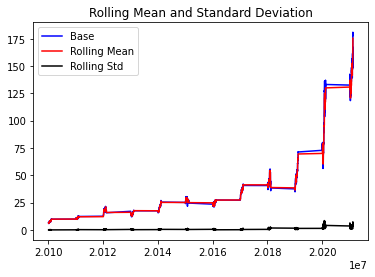

Results of dickey fuller test
Test Statistics            3.507873
p-value                    1.000000
# lags                    27.000000
# observations used     2993.000000
critical value (1%)       -3.432537
critical value (5%)       -2.862506
critical value (10%)      -2.567284
dtype: float64


In [ ]:
test_stationarity(stock['open'])

In [ ]:
result = seasonal_decompose(stock['open'], model='multiplicative', period = 30)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 8)

TypeError: ignored

In [ ]:
df_log = np.log(stock['close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

#Separating the training and testing
train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

In [ ]:
#Auto-correlation
plt.rcParams["figure.figsize"] = (16,8)
plot_acf(Y**2)
plt.show()

#Partial Auto-correlation
plot_pacf(Y**2)
plt.show()

NameError: ignored

In [ ]:
#Selecting the mest ARIMA combination
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_autoARIMA.summary())

model_autoARIMA.plot_diagnostics(figsize=(15,8))

plt.show()

NameError: ignored

In [ ]:
import statsmodels.api as sm

In [ ]:
model = ARIMA(train_data, order=(9,1,0))

In [ ]:
model=sm.tsa.ARIMA(train_data,order=(10, 1, 10))

  
arima_model = model.fit()

print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 2717
Model:               ARIMA(10, 1, 10)   Log Likelihood                7784.513
Method:                       css-mle   S.D. of innovations              0.014
Date:                Sun, 10 Apr 2022   AIC                         -15525.027
Time:                        11:24:39   BIC                         -15395.066
Sample:                             1   HQIC                        -15478.044
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           9.541e-05      0.000      0.359      0.720      -0.000       0.001
ar.L1.D.close     -0.3704      0.448     -0.827      0.409      -1.249       0.508
ar.L2.D.close      0.5162      0.163

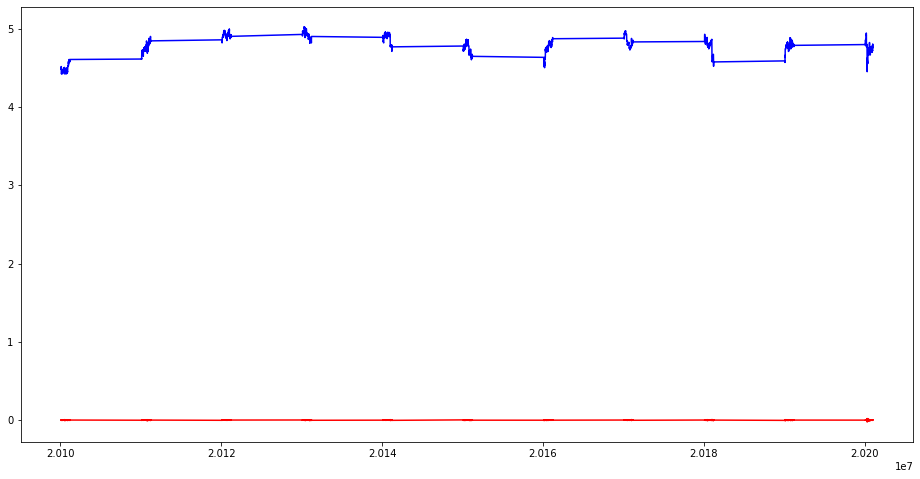

In [ ]:
#train,test -> after the log / difference
plt.plot(train_data,color='blue')

model = ARIMA(train_data[1:], order=(9,1,0))
results = model.fit()
plt.plot(results.fittedvalues[1:], color='red')

# DTC


In [ ]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt


In [ ]:
stock['Return'] = stock['open'].pct_change(50).shift(-100)
features = ['open','volume']

In [ ]:
stock


,open,high,low,close,volume,boll,boll_ub,boll_lb,macd,macdh,macds,rsi_11,rsi_14,rsi_21,Return
20100104,89.397,90.611,89.166,90.250,9032973.0,87.76670,92.164131,83.369269,0.936650,0.124047,0.812602,62.623080,61.195272,58.749163,-0.031182
20100105,89.718,89.861,88.662,89.166,10039865.0,87.53055,91.873404,83.187696,0.856685,0.075094,0.781590,57.855781,57.351330,55.988022,-0.012812
20100106,89.049,89.613,88.460,88.584,8225851.0,87.35335,91.704434,83.002266,0.852530,0.089713,0.762817,55.057942,55.135675,54.428269,-0.032143
20100107,88.504,88.761,87.840,88.291,8572208.0,87.11435,91.699627,82.529073,0.894085,0.153697,0.740389,53.649660,54.018978,53.640536,-0.017833
20100108,87.939,89.210,87.930,89.166,6150552.0,86.90845,91.638795,82.178105,0.963952,0.261988,0.701964,58.638095,58.023928,56.413991,-0.001491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211227,129.080,130.080,128.400,130.050,4346229.0,131.45000,133.282321,129.617679,-0.099397,-0.058552,-0.040846,8.180361,8.545592,8.997984,NaN
20211228,130.030,131.630,130.020,131.050,3488601.0,131.80000,132.899939,130.700061,-0.042801,-0.026749,-0.016052,14.491914,14.911940,15.424720,NaN
20211229,130.820,132.610,130.730,131.760,4291007.0,132.05000,132.611070,131.488930,-0.010219,-0.007870,-0.002349,28.868360,29.305681,29.832936,NaN
20211230,132.160,132.770,131.740,132.320,3196152.0,132.19500,132.548553,131.841447,0.005609,0.002493,0.003116,100.000000,100.000000,100.000000,NaN


In [ ]:
train_X = custom_split(stock,start = 20130101,end = 20181231)
test_X = custom_split(stock,start = 20190101,end = 20201231)

In [ ]:
x_train = train_X[features]
x_test= test_X[features]

y_train = np.where(train_X.Return > 0,1,0)
y_test = np.where(test_X.Return> 0,1,0)

In [ ]:
TC = DecisionTreeClassifier(max_depth=3,min_samples_leaf=6)
TC.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=6)

In [ ]:
y_pred = TC.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.45      0.14      0.21       209
           1       0.59      0.88      0.71       296

    accuracy                           0.57       505
   macro avg       0.52      0.51      0.46       505
weighted avg       0.53      0.57      0.50       505



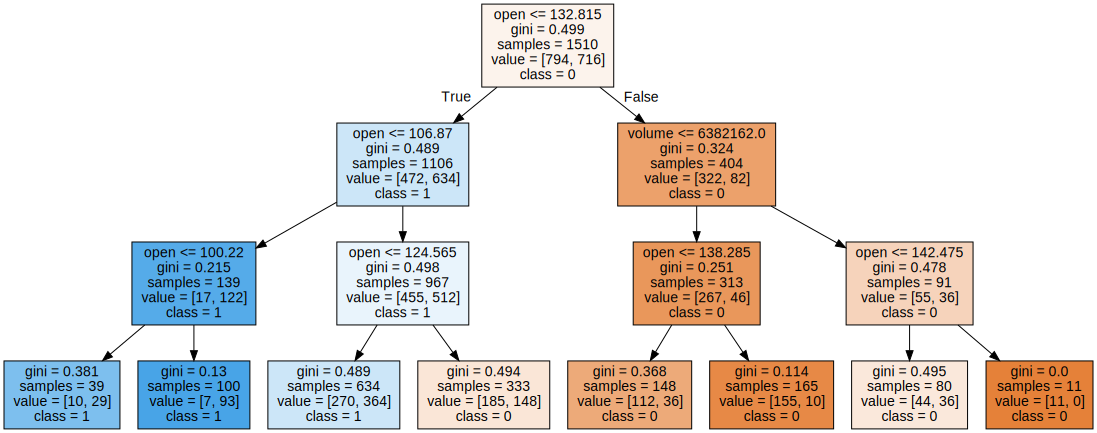

In [ ]:
from sklearn import tree 
import graphviz
data = tree.export_graphviz(TC,filled=True,feature_names=features,class_names=np.array(['0','1']))
graphviz.Source(data)

# SVR

## Model Training


In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from datetime import datetime

In [ ]:
stock_svr = stock.reset_index()

In [ ]:
dates = stock_svr.index.tolist()
dates_arr = [[i]for i in dates]

In [ ]:
High = stock['High'].tolist()

In [ ]:
from sklearn.model_selection import train_test_split
train_X,test_X,train_Y,test_Y = train_test_split(dates_arr, High, test_size = 0.25)

In [ ]:
lin_svr = SVR(kernel='linear')

poly_svr = SVR(kernel='poly', C=1000.0, degree = 2)

rbf_svr = SVR(kernel='rbf', C=1000.0, gamma=0.15)

In [ ]:
lin_svr.fit(train_X,train_Y)
poly_svr.fit(train_X,train_Y)
rbf_svr.fit(train_X,train_Y)

SVR(C=1000.0, gamma=0.15)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from joblib import dump , load

In [ ]:
dump(rbf_svr,"model.rbf_svr")

['model.rbf_svr']

## Load Model and get prediction

In [ ]:
rbf_svr = load("/content/model.rbf_svr")

In [ ]:
rbf_svr_predict = rbf_svr.predict(test_X)

print('rbf_svr:')
print('   r2 score: '+str(r2_score(test_Y, rbf_svr_predict)))
print('   RMSE : '+str(np.sqrt(mean_squared_error(test_Y, rbf_svr_predict))))
print("   Mean Absolute Error : " + str(mean_absolute_error(test_Y, rbf_svr_predict)))

rbf_svr:
   r2 score: 0.9939272157897654
   RMSE : 0.9560222247777088
   Mean Absolute Error : 0.6040822569224105


# Backtesting

In [ ]:
start_date = "2019-01-01"
end_date = "2020-12-31"
bt_stock = web.DataReader('CCL', 'stooq',start=start_date, end=end_date)

In [ ]:
bt_stock = bt_stock.reindex(index=bt_stock.index[::-1])

In [ ]:
bt_stock_svr = bt_stock.reset_index()

In [ ]:
bt_stock_svr

,Date,Open,High,Low,Close,Volume
0,2019-01-02,46.454,47.555,46.149,47.317,4137158
1,2019-01-03,46.766,46.900,44.926,44.964,6456397
2,2019-01-04,45.978,47.858,45.875,47.508,4812828
3,2019-01-07,48.420,48.636,47.772,48.068,4946387
4,2019-01-08,49.737,49.852,48.865,49.263,6085600
...,...,...,...,...,...,...
500,2020-12-24,20.980,21.080,20.430,20.840,14819299
501,2020-12-28,21.310,22.050,21.020,21.710,33112842
502,2020-12-29,22.220,22.270,21.360,21.430,26851152
503,2020-12-30,21.520,22.090,21.380,21.790,23606415


In [ ]:
dates = bt_stock_svr.index.tolist()
dates_arr = [[i]for i in dates]

In [ ]:
predictions = rbf_svr.predict(dates_arr)

In [ ]:
print("predictions shape:", predictions.shape)

predictions shape: (505,)


In [ ]:
print(predictions)

[24.92075202 24.55092831 24.55199417 24.61895578 25.12122114 25.44308776
 25.4347943  25.94076805 26.62338517 26.66797184 26.78335341 27.1638211
 26.7189146  25.92716403 25.80557346 25.76496561 25.81432518 26.29691843
 26.26933955 25.94010985 26.24075152 26.22691838 25.3624343  24.96447264
 25.34111157 25.50446689 25.2944454  25.06880632 25.03527729 25.36403672
 25.77118533 25.91267033 25.86333202 25.70684513 25.87707679 27.30711553
 29.9086516  31.84914701 31.44158552 29.25596125 27.50296044 27.37191136
 28.01560326 28.31394305 28.23001107 28.20493007 28.33745645 28.38375455
 28.28227308 28.30556397 28.52267603 28.7229352  28.84553033 28.95894268
 29.10821767 29.33032229 29.54760697 29.64672178 29.72315468 29.87288764
 29.99232912 30.05770522 30.09114072 29.9481595  29.65508193 29.51241842
 29.6306126  29.8679032  30.14029469 30.36509596 30.25320446 29.78674686
 29.67607299 30.24068893 30.90575032 31.74832768 32.98949287 33.39410102
 32.47947439 32.00416589 32.62383362 32.78247921 32.

In [ ]:
bt_stock_svr['5_days_avg'] =  bt_stock_svr['High'].rolling(window=10,min_periods=1).mean()

In [ ]:
def convert_decision(test,pred):
    h = np.array(pred)
    action = []
    status = "N"
    for i in range(0,5):
        action.append("NA")
    for i in range(5,len(h)):
        if h[i] >= bt_stock_svr['5_days_avg'][i]:
            if status == "N":
                action.append("Buy")
                status = "Buy"
            else:
                action.append("Hold")
        else:
            if status == "Buy":
                action.append("Sell")
                status = "N"
            else:
                action.append("Hold")
                
    return (pd.DataFrame(action,
                         columns=["Action"]))

In [ ]:
final_pred = convert_decision(dates_arr,predictions)
final_pred

,Action
0,NA
1,NA
2,NA
3,NA
4,NA
...,...
500,Hold
501,Hold
502,Hold
503,Hold


In [ ]:
from math import floor
################### Input ##########################
# For hist_price_data: index=["date"], columns = ["Open"]
# For pred_action: index=["date"], columns = ["Action"] (Buy/Sell)
################### Output #########################
# 1. trading record
# 2. total profit
class backtest:
    hpd = ""
    pred_action=""
    trade_record=pd.DataFrame(index=[],
                              columns=["Action","Price","Position","Cash","Pos_Bal","Cash_Bal","Cum_Profit"],
                             )
    capital = 0
    cash_balance = 0
    profit = 0
    handle_fee = 0
    position = 0
    last_price = 0
    
    def __init__(self,hist_price_data,pred_action,capital,handling_fee):
        self.hpd = hist_price_data
        self.pred_action = pred_action
        self.capital = capital
        self.cash_balance = capital
        self.handle_fee = handling_fee
        trade_record=pd.DataFrame(index=[],
                                  columns=["Action","Price","Position","Cash","Pos_Bal","Cash_Bal","Cum_Profit"],
                                 )
        
    def start_test(self):        
        # For loop to iterate the data
        for ind in self.pred_action.index:
            # Update latest price
            self.last_price = self.hpd["High"][ind]
            
            if self.pred_action.loc[ind,"Action"].lower() == "buy":
                self.buy(ind,self.hpd.loc[ind,"Open"])
            elif self.pred_action.loc[ind,"Action"].lower() == "sell":
                self.sell(ind,self.hpd.loc[ind,"Open"])
            else:
                print("Did not buy at " + str(ind))
            
                
        
    def mark_down_record(self,date,action,price,pos_delta,cash_delta):
        self.trade_record.loc[date,"Action"] = action
        self.trade_record.loc[date,"Price"] = price
        self.trade_record.loc[date,"Position"] = pos_delta
        self.trade_record.loc[date,"Cash"] = cash_delta
        
        self.trade_record.loc[date,"Pos_Bal"] = round(self.position,4)
        self.trade_record.loc[date,"Cash_Bal"] = round(self.cash_balance,3)
        self.trade_record.loc[date,"Cum_Profit"] = round(self.get_profit(),3)
        
    def buy(self,date,price):
        # Assume use all money to buy all
        buy_flag = False
        buy_pos = floor(self.cash_balance / price)
        for i in range(buy_pos):
            act_buy_pos = buy_pos - i
            total_amt = act_buy_pos*price*(1+self.handle_fee)
            if self.cash_balance > total_amt:
                self.position += act_buy_pos
                self.cash_balance -= total_amt
                self.mark_down_record(date,
                                 "Buy",
                                 price,
                                 act_buy_pos,
                                 -total_amt)
                print("Bought at",date,"with price =", price)
                buy_flag = True
                break
        if not buy_flag:
            print("You do not have enough money to buy!")
    
    def sell(self,date,price):
        # Assume sell all position
        sell_pos = self.position
        total_amt = sell_pos*price*(1-self.handle_fee)
        if self.position >= 1:
            self.position -= sell_pos
            self.cash_balance += total_amt
            self.mark_down_record(date,
                             "Sell",
                             price,
                             -sell_pos,
                             total_amt)
            print("Sold at",date,"with price =", price)
        else:
            print("You do not have enough position to sell!")
    
    def get_profit(self):
        return self.get_cash_balance()+self.get_last_price()*self.get_position()-self.get_capital()
    
    def get_capital(self):
        return self.capital
    
    def get_last_price(self):
        return self.last_price
    
    def get_cash_balance(self):
        return self.cash_balance
    
    def get_position(self):
        return self.position
    
    def get_amounnt(self):
        return self.capital+self.profit
    
    def print_trade_record(self):
        print(self.trade_record)
    
    def print_profit(self):
        profit = float(self.get_profit())
        print("Current Profit:",self.get_profit())
        return profit
    
    def export_trade_record(self,stock):
        # Save the trade record to the path
        self.trade_record.to_csv("trade_record/"+stock+".csv")

In [ ]:
def do_nothing(backtest,capital):
    balance = capital

    handling_fee=0
    first_price = backtest["High"][0]
    last_price = backtest["High"][len(backtest)-1]
    buy_pos = floor(capital / first_price)
    total_amt = buy_pos*first_price*(1+handling_fee)
    while capital < total_amt:
        buy_pos -= 1
        total_amt = buy_pos*first_price*(1+handling_fee)
    position = buy_pos
    balance -= total_amt
    print("If buy at", backtest.index[0],"with price =",first_price)
    print("and do nothing")
    print("Current Profit:", last_price*position+balance-capital)
    return last_price*position+balance-capital

In [ ]:
def compare(do_nth_pro,backtest_pro):

    do_nth_pro = float(do_nth_pro)
    backtest_pro = float(backtest_pro)

    percent = ((backtest_pro-do_nth_pro)/abs(do_nth_pro))*100
    print("The profit for doing nothing: " ,do_nth_pro)
    print("The profit for using our platform: ",backtest_pro)
    print("We are ",percent,"% better than doing nothing")



In [ ]:
backtest_1 = backtest(bt_stock_svr,final_pred,10000,0)

In [ ]:
backtest_1.start_test()

Did not buy at 0
Did not buy at 1
Did not buy at 2
Did not buy at 3
Did not buy at 4
Did not buy at 5
Did not buy at 6
Did not buy at 7
Did not buy at 8
Did not buy at 9
Did not buy at 10
Did not buy at 11
Did not buy at 12
Did not buy at 13
Did not buy at 14
Did not buy at 15
Did not buy at 16
Did not buy at 17
Did not buy at 18
Did not buy at 19
Did not buy at 20
Did not buy at 21
Did not buy at 22
Did not buy at 23
Did not buy at 24
Did not buy at 25
Did not buy at 26
Did not buy at 27
Did not buy at 28
Did not buy at 29
Did not buy at 30
Did not buy at 31
Did not buy at 32
Did not buy at 33
Did not buy at 34
Did not buy at 35
Did not buy at 36
Did not buy at 37
Did not buy at 38
Did not buy at 39
Did not buy at 40
Did not buy at 41
Did not buy at 42
Did not buy at 43
Did not buy at 44
Did not buy at 45
Did not buy at 46
Did not buy at 47
Did not buy at 48
Did not buy at 49
Did not buy at 50
Did not buy at 51
Did not buy at 52
Did not buy at 53
Did not buy at 54
Did not buy at 55
Di

In [ ]:
backtest_1.print_trade_record()
print('==========================')
backtest_1.print_profit()
backtest_pro = backtest_1.get_profit()

    Action  Price Position     Cash Pos_Bal Cash_Bal Cum_Profit
299    Buy  22.91      436 -9988.76     436    11.24     344.44
Current Profit: -488.3199999999997


In [ ]:
do_nth_pro = do_nothing(bt_stock_svr,10000)

If buy at 0 with price = 47.555
and do nothing
Current Profit: -5410.65


In [ ]:
compare(do_nth_pro,backtest_pro)

The profit for doing nothing:  -5410.65
The profit for using our platform:  -488.3199999999997
We are  90.97483666472606 % better than doing nothing
